In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DL2022/master/_notebooks/2022-09-22-regression.csv") 
df.head(3)# 주어진 data

,x,y
0,-2.482113,-8.542024
1,-2.362146,-6.576713
2,-1.997295,-5.949576


In [4]:
x= torch.tensor(df.x,dtype=torch.float32).reshape(100,1)
y= torch.tensor(df.y,dtype=torch.float32).reshape(100,1)
X= torch.tensor([[1]*100,x]).T # 100x2

In [5]:
What= torch.tensor([[-5.0],[10.0]],requires_grad=True)
What # 2x1

tensor([[-5.],
        [10.]], requires_grad=True)

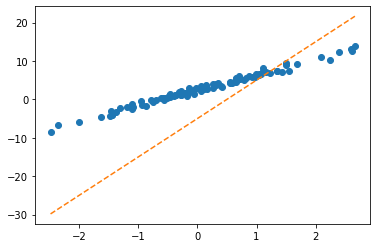

In [6]:
plt.plot(x,y,'o') # 관측 데이터
plt.plot(x,X@What.data,'--') # (100x2)(2x1) = 100x1

## review 

###  `(ver1) loss = sum of squares error`

In [7]:
alpha = 1/1000  # mse면 1/10 사용
What= torch.tensor([[-5.0],[10.0]],requires_grad=True)
for epoc in range(30):
    ## step1
    yhat = X@What # 100x1
    ## step2 
    loss = torch.sum((y-yhat)**2) # loss = (y-yhat).T@(y-yhat) -> (1x100)(100x1) = 1 = loss
    ## step3
    loss.backward() # 미분된 값 저장은 What.grad에 되어있음
    ## step4 
    What.data = What.data - alpha*What.grad 
    What.grad = None # 미분값 누적되지 않게 청소
    
# 왜 What = What - alpha*What.grad는 안되는지?
# 미분꼬리표가 파생된 함수로 변함
# .data를 이용해줘야 미분꼬리표가 원조로 유지됨

In [8]:
What

tensor([[2.4290],
        [4.0144]], requires_grad=True)

### `(ver2) loss = mean squared error = MSE `

In [9]:
alpha = 1/10 
What= torch.tensor([[-5.0],[10.0]],requires_grad=True)
for epoc in range(30):
    ## step1: yhat을 구한다.  
    yhat = X@What 
    ## step2: loss를 계산한다. 
    loss = torch.mean((y-yhat)**2) # loss = (y-yhat).T@(y-yhat)
    ## step3: 미분
    loss.backward()
    ## step4: update  
    What.data = What.data - alpha*What.grad 
    What.grad = None

In [10]:
What

tensor([[2.4290],
        [4.0144]], requires_grad=True)

---

## step1의 다른버전: torch.nn.Linear()

### ver1

In [11]:
torch.manual_seed(43052)

net = torch.nn.Linear(1,1)

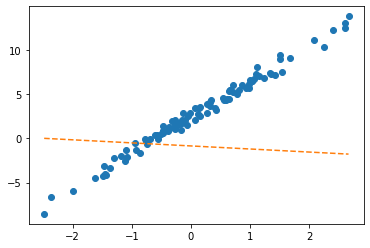

In [12]:
plt.plot(x,y,'o') # 정답 데이터
plt.plot(x,net(x).data,'--')

`-` net에서 $\hat{w}_0, \hat{w}_1$ 의 값은? 

In [13]:
net.weight # w1 

Parameter containing:
tensor([[-0.3467]], requires_grad=True)

In [14]:
net.bias # w0 

Parameter containing:
tensor([-0.8470], requires_grad=True)

In [16]:
_yhat = -0.8470 + -0.3467*x 

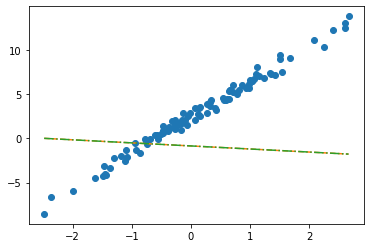

In [18]:
plt.plot(x,y,'o')
plt.plot(x, _yhat,'--') 
plt.plot(x,net(x).data,'-.')

`-` 수식표현: $\hat{y}_i = \hat{w}_0 + \hat{w}_1 x_i = \hat{b} + \hat{w}x_i =  -0.8470 + -0.3467 x_i$ for all $i=1,2,\dots,100$. 

### ver2

`-` 입력이 x가 아닌 X를 넣고 싶다면? (보통 잘 안하긴 해요, 왜? bias=False로 주는게 귀찮거든요)

In [21]:
torch.manual_seed(43052)
net = torch.nn.Linear(2,1, bias=False) 

In [22]:
net.weight
# ver1에서는 입력이 1차원이었으니까 weight가 하나만 나왔음
# X.shape = (100,2)

Parameter containing:
tensor([[-0.2451, -0.5989]], requires_grad=True)

In [23]:
net.bias
# 안 나옴
# bias=False

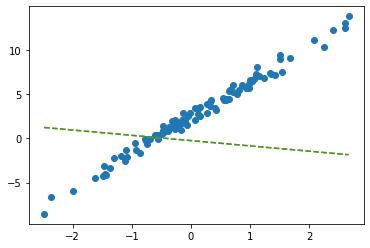

In [24]:
plt.plot(x,y,'o') 
plt.plot(x,net(X).data, '--')
plt.plot(x,X@torch.tensor([[-0.2451],[-0.5989]]), '--')

`-` 수식표현: $\hat{\bf y} = {\bf X} {\bf \hat W} = \begin{bmatrix} 1 & x_1 \\ 1 & x_2 \\ \dots & \dots \\ 1 & x_{100} \end{bmatrix}  \begin{bmatrix} -0.2451 \\ -0.5989  \end{bmatrix}$

### 잘못된사용1

In [25]:
_x = x.reshape(-1)

In [26]:
# 열벡터,행벡터도 아니고 그냥 수들의 집합인 vector
_x.size()

torch.Size([100])

In [27]:
torch.manual_seed(43052)
net = torch.nn.Linear(in_features=1,out_features=1) 

In [37]:
net(_x)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x100 and 1x1)

### 잘못된사용2

In [38]:
torch.manual_seed(43052)
net = torch.nn.Linear(in_features=2,out_features=1) 
# bias=False를 깜빡..
#에러는 안 나지만 잘못된 방식임

In [39]:
net.weight

Parameter containing:
tensor([[-0.2451, -0.5989]], requires_grad=True)

In [40]:
net.bias

Parameter containing:
tensor([0.2549], requires_grad=True)

- bias가 두번 할당된 셈

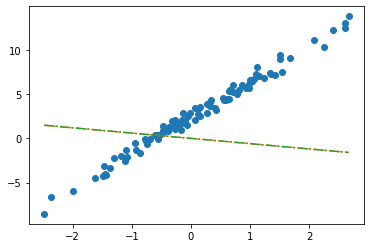

In [41]:
plt.plot(x,y,'o')
plt.plot(x,net(X).data,'--')
plt.plot(x,X@torch.tensor([[-0.2451],[-0.5989]])+0.2549,'-.')
# bias가 두번 더해진 꼴
# 원래는 -0.2451에서 끝났어야 함

- 수식표현: $\hat{\bf y} = {\bf X} {\bf \hat W} + \hat{b}= \begin{bmatrix} 1 & x_1 \\ 1 & x_2 \\ \dots & \dots \\ 1 & x_{100} \end{bmatrix}  \begin{bmatrix} -0.2451 \\ -0.5989  \end{bmatrix} + 0.2549$

## step2의 다른버전: torch.nn.MSELoss()

In [28]:
What = torch.tensor([[-5.0],[10.0]],requires_grad=True)
yhat = X@What

### ver1

In [29]:
loss_fn = torch.nn.MSELoss()

loss = loss_fn(y,yhat)
loss

tensor(85.8769, grad_fn=<MseLossBackward0>)

In [30]:
y.shape

torch.Size([100, 1])

In [31]:
yhat.shape

torch.Size([100, 1])

### 잘못된사용1 

In [32]:
y.shape

torch.Size([100, 1])

In [33]:
_y = y.reshape(-1)
_y.shape

torch.Size([100])

In [35]:
loss_fn(_y,yhat)
# 틀린 loss임
# 차원 조심하자

tensor(176.2661, grad_fn=<MseLossBackward0>)

> 미분은 무조건 `loss.backward()`로 하면된다. 

`-` 그런데 step1에서 정의한 다른 방식들에 의해서 미분된값이 저장되는 루트는 다름 

`-` net를 생성 

In [36]:
torch.manual_seed(43052)
net = torch.nn.Linear(1,1) 

`-` net의 weight와 bias가 $y_i=\hat{w}x_i + \hat{b}=10x_i - 5$와 같이 되도록 설정 

In [37]:
net.weight # what = -0.3467 

Parameter containing:
tensor([[-0.3467]], requires_grad=True)

In [38]:
net.weight.data = torch.tensor([[10.00]]) 

In [39]:
net.weight # 이제 what = 10.00 

Parameter containing:
tensor([[10.]], requires_grad=True)

In [40]:
net.bias # 지금 bhat = -0.8470

Parameter containing:
tensor([-0.8470], requires_grad=True)

In [41]:
net.bias.data = torch.tensor([-5.0]) # 이제 bhat = -5.0

In [42]:
net.bias

Parameter containing:
tensor([-5.], requires_grad=True)

`-` yhat계산 $\to$ loss계산 $\to$ 미분 $\to$ 미분값확인 

In [43]:
yhat = net(x) 

In [44]:
loss = loss_fn(y,yhat)

In [45]:
loss.backward()

In [46]:
net.bias.grad,net.weight.grad

(tensor([-13.4225]), tensor([[11.8893]]))

- 전 파일에선 미분 값을 What.grad로 확인했었음
  - 그 파일에선 net를 사용하지 않고 수작업으로 What에 미분꼬리표를 설정하였기 때문에 가능

### 예시3: (ver2) 

`-` net를 생성 

In [47]:
torch.manual_seed(43052)
net = torch.nn.Linear(in_features=2, out_features=1, bias=False) 

`-` net의 weight와 bias가 $y_i=\hat{w}x_i + \hat{b}=10x_i - 5$와 같이 되도록 설정 

In [48]:
net.weight 

Parameter containing:
tensor([[-0.2451, -0.5989]], requires_grad=True)

In [49]:
net.weight.data = torch.tensor([[-5.00,10.00]]) 
# 수정해줄 때 net.weight에서 반환하는 결과대로 반환을 해줘야 함

# 그런데 사실 입력이 100x2
# 따라서 weight도 2x1이어야 함
# 즉 torch.tensor([[-5.0],[10.0]])이래야 함

# 그런데 그냥 torch 설계상 그런 것 뿐
# 따라서 net.weight보고 반환된 형식대로 값을 변경해주면 된다

In [50]:
net.weight 

Parameter containing:
tensor([[-5., 10.]], requires_grad=True)

`-` yhat계산 $\to$ loss계산 $\to$ 미분 $\to$ 미분값확인 

In [51]:
yhat = net(X) 

In [52]:
loss = loss_fn(y,yhat) 

In [53]:
loss.backward()

In [109]:
net.weight.grad
# 미분값 확인

tensor([[-13.4225,  11.8893]])